# P03_02_Univar_LSTM

In [1]:
section_fig_main_title = 'P03_02_Univar_LSTM_'

In [2]:
import os, sys
import requests
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import lag_plot

In [3]:

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflo

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [5]:
# !/Users/amin/anaconda3/bin/python -m pip install pmdarima
# !/Users/amin/anaconda3/bin/python -m pip install statsmodels

In [6]:
from pandas.plotting import autocorrelation_plot
import gif

In [7]:
# !pip install statsmodels --upgrade
# !/Users/amin/anaconda3/bin/python -m pip install statsmodels --upgrade

In [8]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [9]:
import tensorflow as tf
tf.__version__

import tensorflow as tf
from tensorflow import keras

import gif
from tqdm import tqdm



In [10]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
from sklearn import metrics
import statsmodels.api as sm

## Read Data 

Using the univariate evenly spaced time series data from P03_01.

In [12]:
csv_path = "../Data/Data_ICME_speed_transformed_18D_P03_01"
df = pd.read_pickle(csv_path)

In [13]:
df.head()

ICME Plasma/Field Start Y/M/D (UT) (b)
1996-06-14    370.0
1996-07-02    360.0
1996-07-20    360.0
1996-08-07    360.0
1996-08-25    350.0
Freq: 18D, Name: V_ICME (km/s) (i), dtype: float64

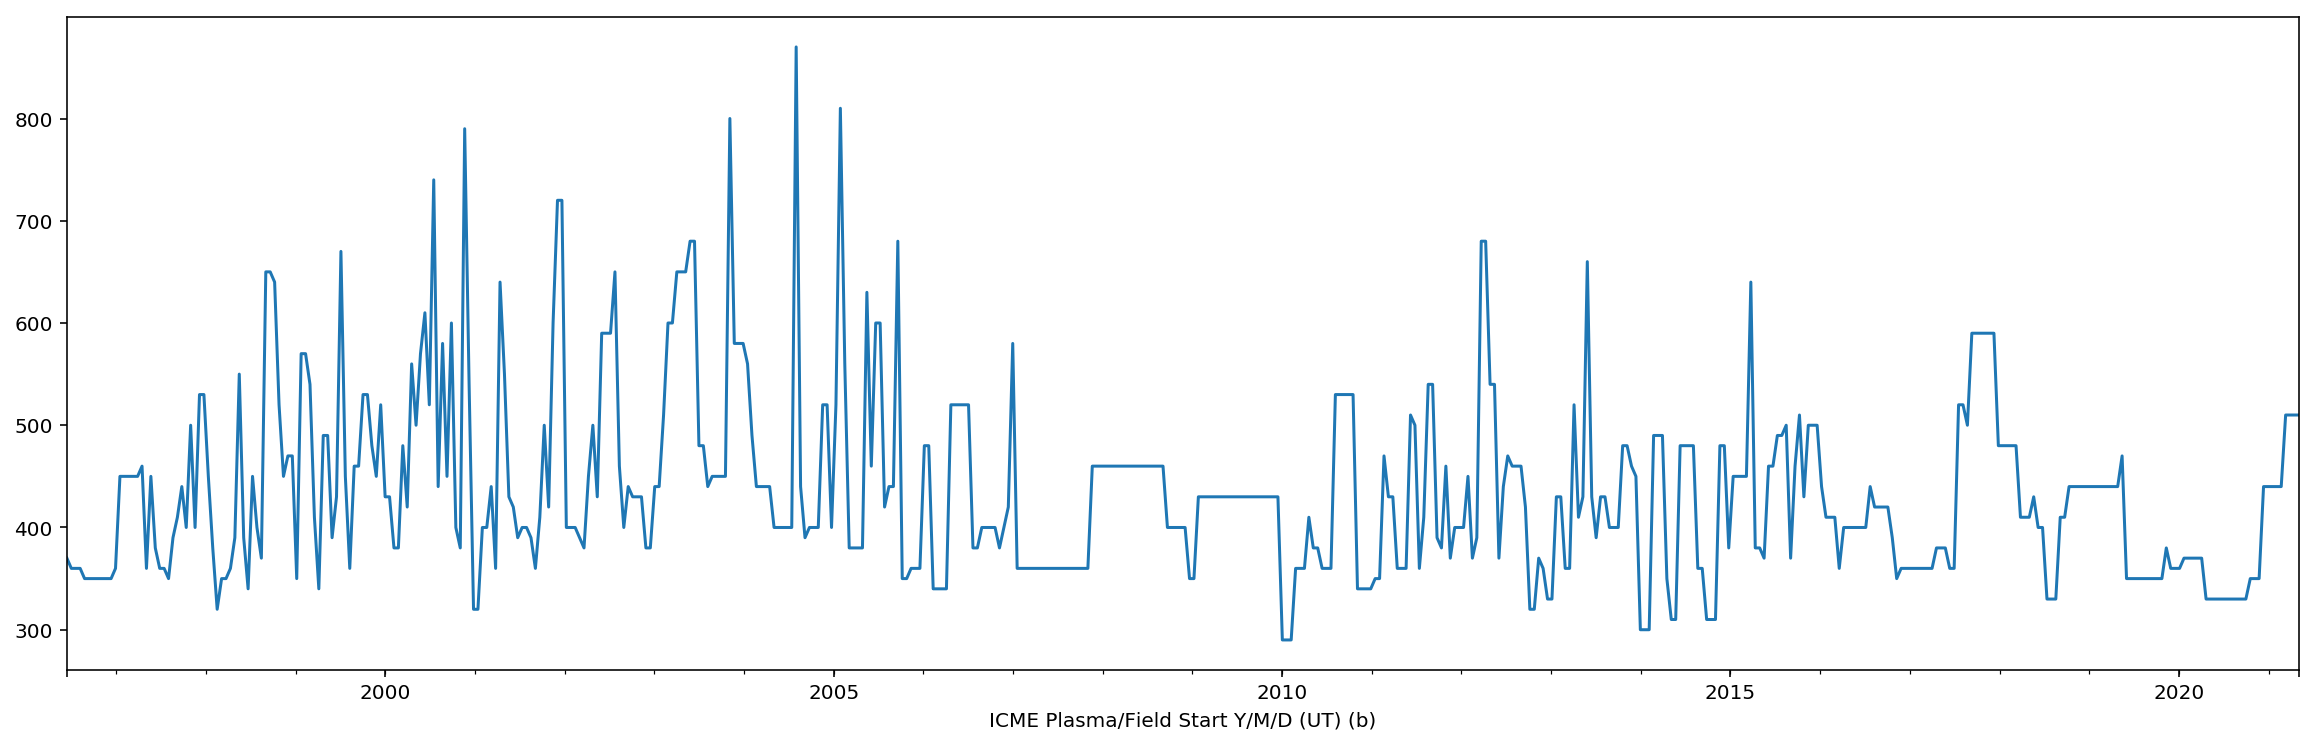

In [14]:
df.plot(figsize=(20,6))

## Set data parameters


In [15]:
len(df)

506

In [16]:
len(df)*.69

349.14

In [17]:
# use first 347 timestamps for training 
size_of_training = 347

In [18]:
df[0:1].index[0]

Timestamp('1996-06-14 00:00:00', freq='18D')

In [19]:
# set the start of training row date
train_start = df[0:1].index[0]
train_start = str(train_start)
train_start

'1996-06-14 00:00:00'

In [20]:
a = df[0:1].index[0]
str(a)

'1996-06-14 00:00:00'

In [21]:
# set the end of training row date
train_end = df[(size_of_training-1):size_of_training].index[0]
train_end = str(train_end)
train_end

'2013-07-03 00:00:00'

In [22]:
# use last 60 time stamps for prediction one timestamps ahead (18 days ahead)
lags = 60

I subtract the length of training from whole data to come up with test data set length.


In [23]:
len(df) - 347

159

I use the next 156 timestamps in the dataset as test data set which should be used for model prediction performance.

however, I need to include the number of lags necessary for the test set. keep that in mind I need to separate the data from the main data set from row 347 to the end and, I have to subtract the 347 from 60 (lag time stamps) which later I would need for predicting the first row of the data set (I need 60 lags reading to forecast the next ICME speed).

Let's find the date of the first row of the test data set.

In [24]:
next_timestamps_test_num = 156 # number of timestamps available for prediction - test set

In [25]:
print(size_of_training-lags)

287


So the test data set row begin from row number 287. let's check out the date asigned to row 287.

In [26]:
df[287:288].index[0]

Timestamp('2010-08-06 00:00:00', freq='18D')

In [27]:
test_start = df[(size_of_training-lags-1):(size_of_training-lags)].index[0]
test_start = str(test_start)
test_start

'2010-07-19 00:00:00'

test data set should come to end at 503 (the end of whole data set = len(df)). lets check out the date asigned to row 503.

In [28]:
df[502:503].index[0]

Timestamp('2021-03-11 00:00:00', freq='18D')

In [29]:
test_end = df[(size_of_training+next_timestamps_test_num-1):(size_of_training+next_timestamps_test_num)].index[0]
test_end = str(test_end)
test_end

'2021-03-11 00:00:00'

### Train and Test df

In [30]:

training_set = df[train_start:train_end]
test_set = df[test_start:test_end]

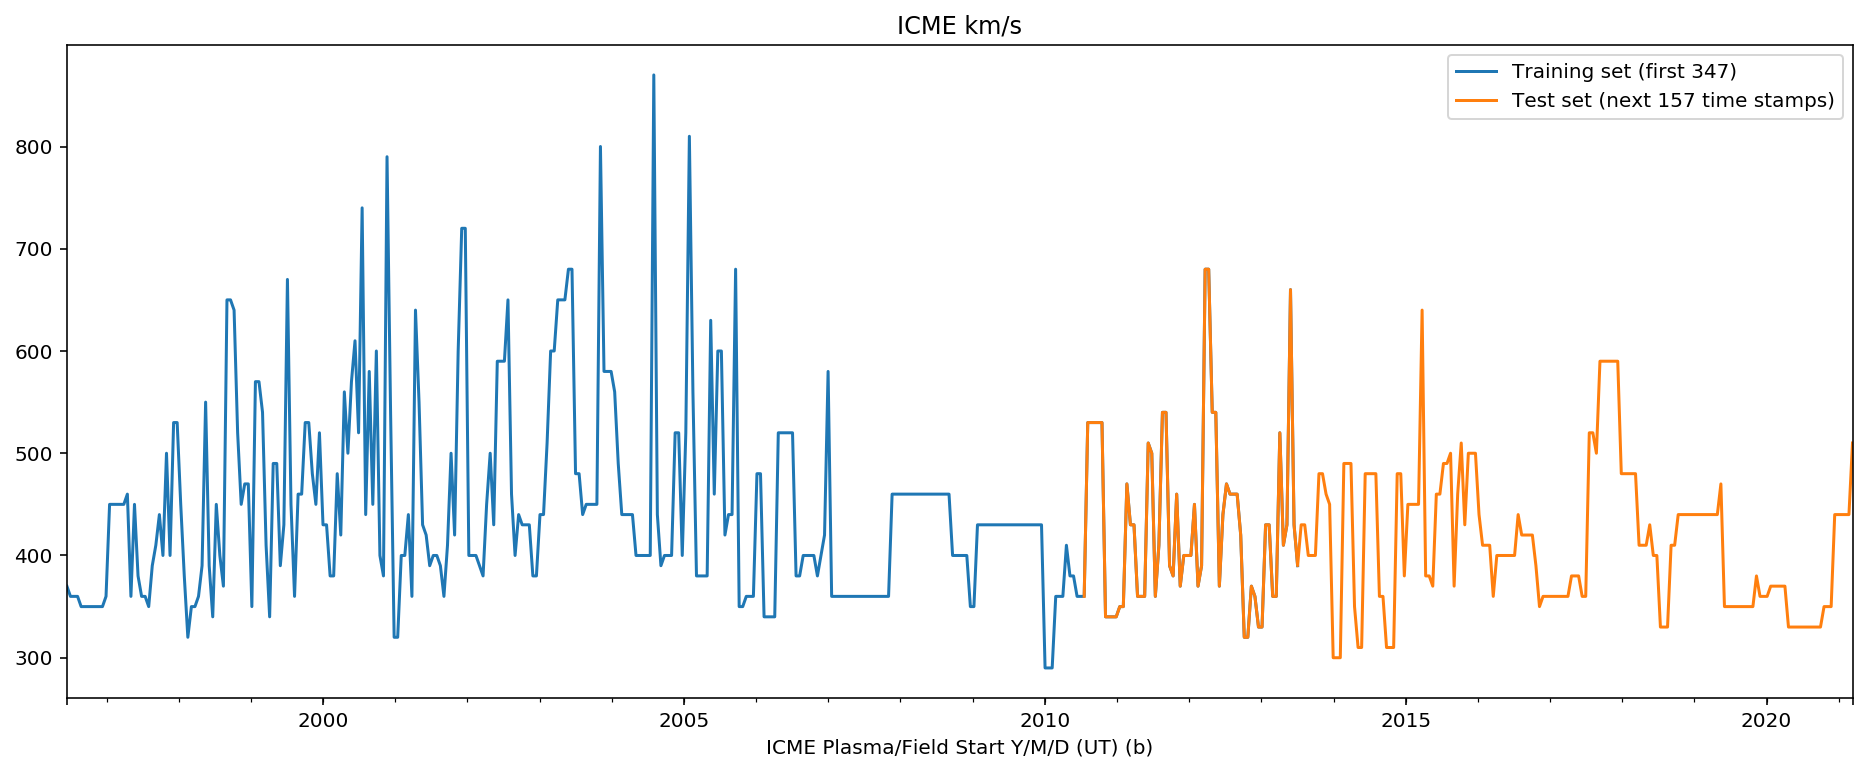

In [31]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
training_set.plot(figsize=(16,6),legend=True)
test_set.plot(figsize=(16,6),legend=True)
plt.legend(['Training set (first 347)','Test set (next 157 time stamps)'])
plt.title('ICME km/s')
plt.show()

## Preparing train data set


In [32]:
# training_set.values
training_set_np = np.array(training_set)
# training_set_np
training_set_np = training_set_np.reshape(-1,1)
# training_set_np

In [33]:

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set_np)

In [34]:
training_set_scaled.size

347

Using 60 timestamps for pridction next timestamp.

In [35]:
X_train = []
y_train = []

num_use_past_data = lags # 60
size_of_training = training_set_scaled.size 



for i in range(num_use_past_data, size_of_training):
    X_train.append(training_set_scaled[i-num_use_past_data:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [36]:
X_train.shape

(287, 60)

In [37]:
y_train.shape

(287,)

In [38]:

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM_1

In [39]:
# lstm source https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressor.add(Dropout(0.2))


# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.2))


# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))


# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))



# The output layer
regressor.add(Dense(units=1))


# Compiling the RNN
regressor.compile(optimizer='rmsprop', 
                  loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:

regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total para

In [41]:
path_checkpoint = "../Models/LSTM_1_univariate.h5"
# es_callback = keras.callbacks.EarlyStopping(monitor="loss", 
#                                             min_delta=0, 
#                                             patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
                                                    monitor="loss",
                                                    filepath=path_checkpoint,
                                                    verbose=0,
                                                    #save_weights_only=True,
                                                    #save_best_only=True,
                                                    )


# Fitting to the training set


history = regressor.fit(X_train, y_train,
                    epochs=10,
                    #validation_data=dataset_val,
                    callbacks=[modelckpt_callback], #es_callback, 
                )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
287/287 [==============================] - 3s 11ms/step - loss: 0.0533
Epoch 2/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0301
Epoch 3/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0330
Epoch 4/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0304
Epoch 5/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0306
Epoch 6/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0289
Epoch 7/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0292
Epoch 8/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0307
Epoch 9/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0301
Epoch 10/10
287/287 [==============================] - 1s 4ms/step - loss: 0.0280


In [42]:
model_history_df = pd.DataFrame(history.history)
model_history_df.columns

Index(['loss'], dtype='object')

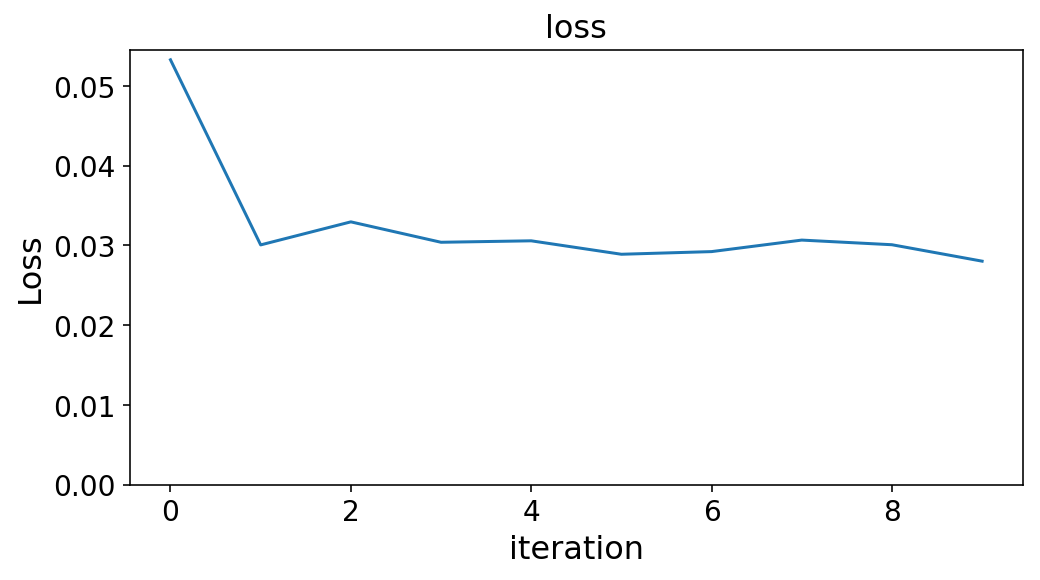

In [43]:
plt.figure(figsize=(8,4))
plt.plot(model_history_df['loss'])
plt.title('loss', fontsize=16)
plt.xlabel("iteration", fontsize=16), plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.ylim(0,)
plt.show()
# plt.savefig("plot_01_1_4classes_balanced_second_app.png")

## LSTM_2

In [45]:
# shape=(inputs.shape[1], )
# shape

In [165]:
inputs = X_train


inputs = keras.layers.Input(shape=(inputs.shape[1], 
                                   inputs.shape[2]))

lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(50)(lstm_out)

# lstm_out = keras.layers.LSTM(32)(inputs)
# outputs2 = keras.layers.LSTM(32)(outputs)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), 
              loss="mse")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 60, 1)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                1650      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________


In [166]:
inputs.shape

TensorShape([Dimension(None), Dimension(60), Dimension(1)])

In [167]:
outputs2.shape

TensorShape([Dimension(None), Dimension(1)])

In [168]:
path_checkpoint = "../Models/LSTM_2_univariate.h5"
# es_callback = keras.callbacks.EarlyStopping(monitor="loss", 
#                                             min_delta=0, 
#                                             patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
                                                    monitor="loss",
                                                    filepath=path_checkpoint,
                                                    verbose=0,
                                                    #save_weights_only=True,
                                                    #save_best_only=True,
                                                    )

history = model_LSTM_2.fit(X_train, y_train,
                    epochs=10,
                    #validation_data=dataset_val,
                    callbacks=[modelckpt_callback], #es_callback, 
                )

Epoch 1/10
287/287 [==============================] - 2s 8ms/sample - loss: 0.0243
Epoch 2/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0243
Epoch 3/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0243
Epoch 4/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0244
Epoch 5/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0240
Epoch 6/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0239
Epoch 7/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0240
Epoch 8/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0241
Epoch 9/10
287/287 [==============================] - 0s 1ms/sample - loss: 0.0237
Epoch 10/10
287/287 [==============================] - 0s 2ms/sample - loss: 0.0237


In [169]:
# history.history

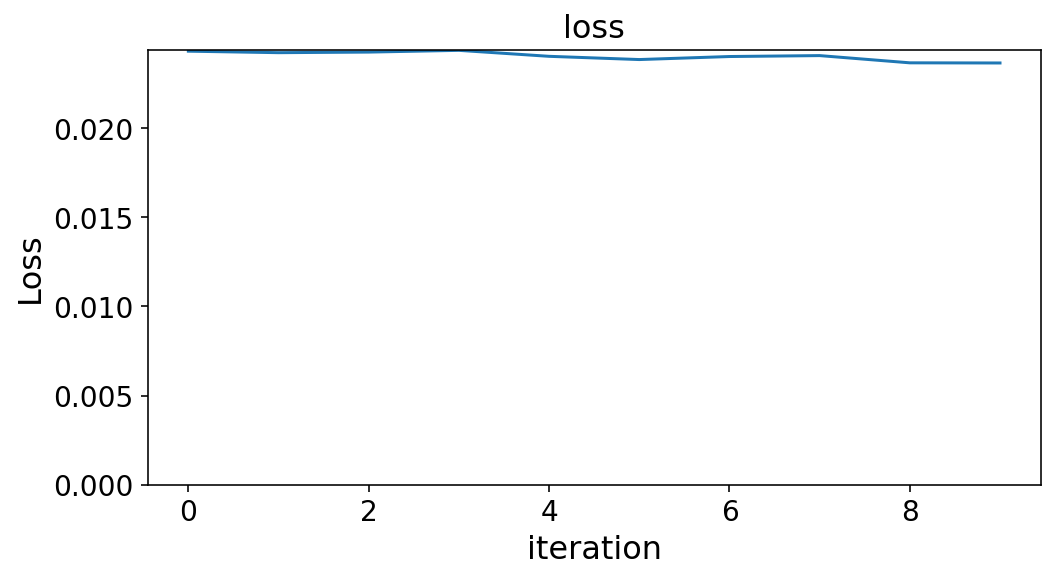

In [170]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.title('loss', fontsize=16)
plt.xlabel("iteration", fontsize=16), plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.ylim(0,)
plt.show()
# plt.savefig("plot_01_1_4classes_balanced_second_app.png")

We don't have validation here however by checking out the test data set we would be able to say if the model is good enough or not.

## Preparing test data set


In [171]:
# test_set.values
test_set_np = np.array(test_set)
# test_set_np
test_set_np = test_set_np.reshape(-1,1)
# test_set_np

In [172]:
# Scaling the test set
inputs = sc.fit_transform(test_set_np)

## Load the Model

In [188]:
# path = '../Models/LSTM_1_univariate.h5'
path = '../Models/LSTM_2_univariate.h5'
regressor = keras.models.load_model(path)

In [189]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,053
Trainable params: 6,053
Non-trainable params: 0
_________________________________________________________________


In [190]:
# Preparing X_test and prediction
X_test = []
for i in range(lags,(next_timestamps_test_num+lags)):
    X_test.append(inputs[i-lags:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_ICME = regressor.predict(X_test)
predicted_ICME = sc.inverse_transform(predicted_ICME)

seperate the correct test data set and cut off the first 60 lags.

In [191]:
test_set_edited = test_set[61:]
test_set_edited.size

156

make sure that the data is in same format.

In [192]:
print(type(predicted_ICME))
print(type(np.array(test_set_edited)))
test_set_edited_np = np.array(test_set_edited)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [193]:
# predictions = pd.Series(predicted_ICME)
# predictions.index = test_set_edited_np.index

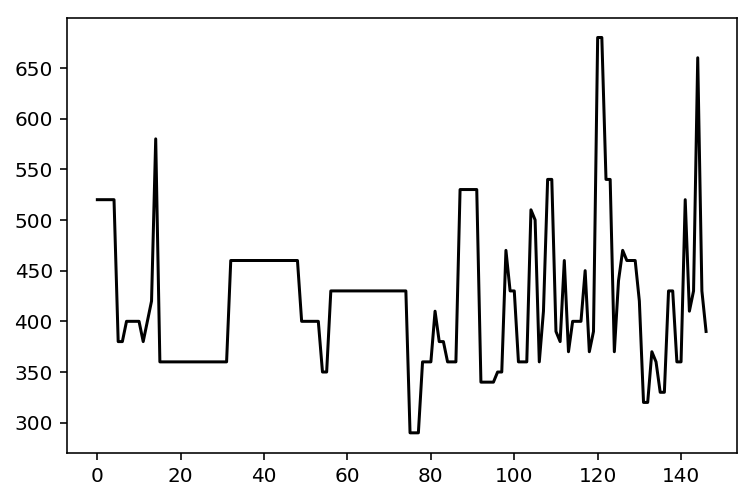

In [194]:
plt.plot(np.array(df[200:347]), 'k',label='history')

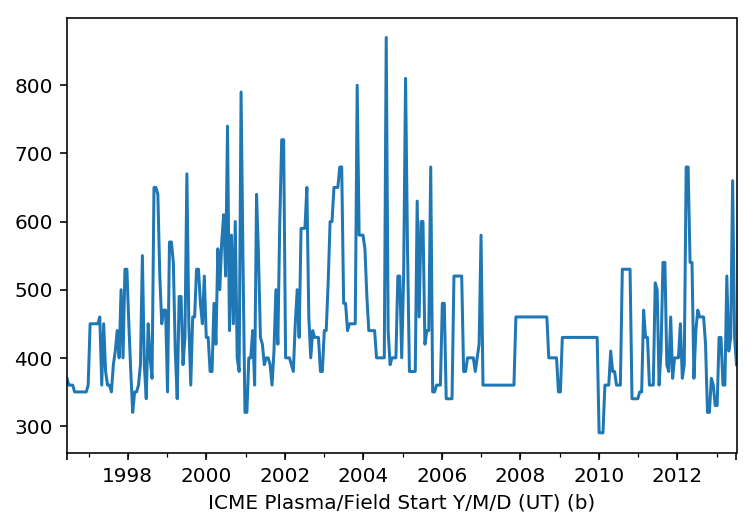

In [195]:
training_set.plot()

In [196]:
test_set

ICME Plasma/Field Start Y/M/D (UT) (b)
2010-07-19    360.0
2010-08-06    530.0
2010-08-24    530.0
2010-09-11    530.0
2010-09-29    530.0
              ...  
2020-12-29    440.0
2021-01-16    440.0
2021-02-03    440.0
2021-02-21    440.0
2021-03-11    510.0
Freq: 18D, Name: V_ICME (km/s) (i), Length: 217, dtype: float64

using test set series and replacing the values with a predicted values which I later use for plot purposes.

In [197]:
len(predicted_ICME)

156

In [198]:
predicted_ICME.shape

(156, 1)

In [199]:
predicted_ICME_reshaped = predicted_ICME.reshape(-1,)
predicted_ICME_reshaped.shape

(156,)

In [200]:
predicted_ICME_timeseri = test_set[61:]
print('predicted_ICME_timeseri \n\n',predicted_ICME_timeseri.head())

print('\nshape \n\n', predicted_ICME_timeseri.shape)

type(predicted_ICME_timeseri)
type(predicted_ICME)

predicted_ICME_reshaped = predicted_ICME.reshape(-1, )
predicted_ICME_reshaped_ser = pd.Series(predicted_ICME_reshaped)


predicted_ICME_reshaped_ser.index = test_set[61:].index
predicted_ICME_reshaped_ser
# predicted_ICME_timeseri.values = predicted_ICME_reshaped
df[347:348][0]

predicted_ICME_timeseri 

 ICME Plasma/Field Start Y/M/D (UT) (b)
2013-07-21    430.0
2013-08-08    430.0
2013-08-26    400.0
2013-09-13    400.0
2013-10-01    400.0
Freq: 18D, Name: V_ICME (km/s) (i), dtype: float64

shape 

 (156,)


430.0

In [212]:
test_set[61:]

ICME Plasma/Field Start Y/M/D (UT) (b)
2013-07-21    430.0
2013-08-08    430.0
2013-08-26    400.0
2013-09-13    400.0
2013-10-01    400.0
              ...  
2020-12-29    440.0
2021-01-16    440.0
2021-02-03    440.0
2021-02-21    440.0
2021-03-11    510.0
Freq: 18D, Name: V_ICME (km/s) (i), Length: 156, dtype: float64

In [211]:
predicted_ICME_reshaped_ser

ICME Plasma/Field Start Y/M/D (UT) (b)
2013-07-21    447.279541
2013-08-08    426.180603
2013-08-26    423.488770
2013-09-13    421.784363
2013-10-01    414.027649
                 ...    
2020-12-29    372.185547
2021-01-16    393.378632
2021-02-03    405.508087
2021-02-21    412.588379
2021-03-11    416.741547
Freq: 18D, Length: 156, dtype: float32

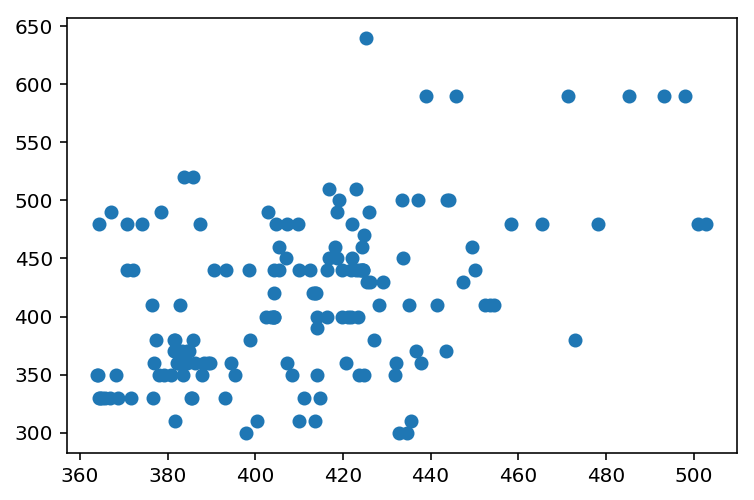

In [214]:
plt.scatter(predicted_ICME_reshaped_ser, test_set[61:])

In [216]:
from sklearn.metrics import r2_score
real_values = test_set[61:]
predited_values = predicted_ICME_reshaped_ser


coefficient_of_dermination = r2_score(real_values, predited_values)
coefficient_of_dermination

0.22612470058774425

In [217]:
rs2 = round(coefficient_of_dermination,2)

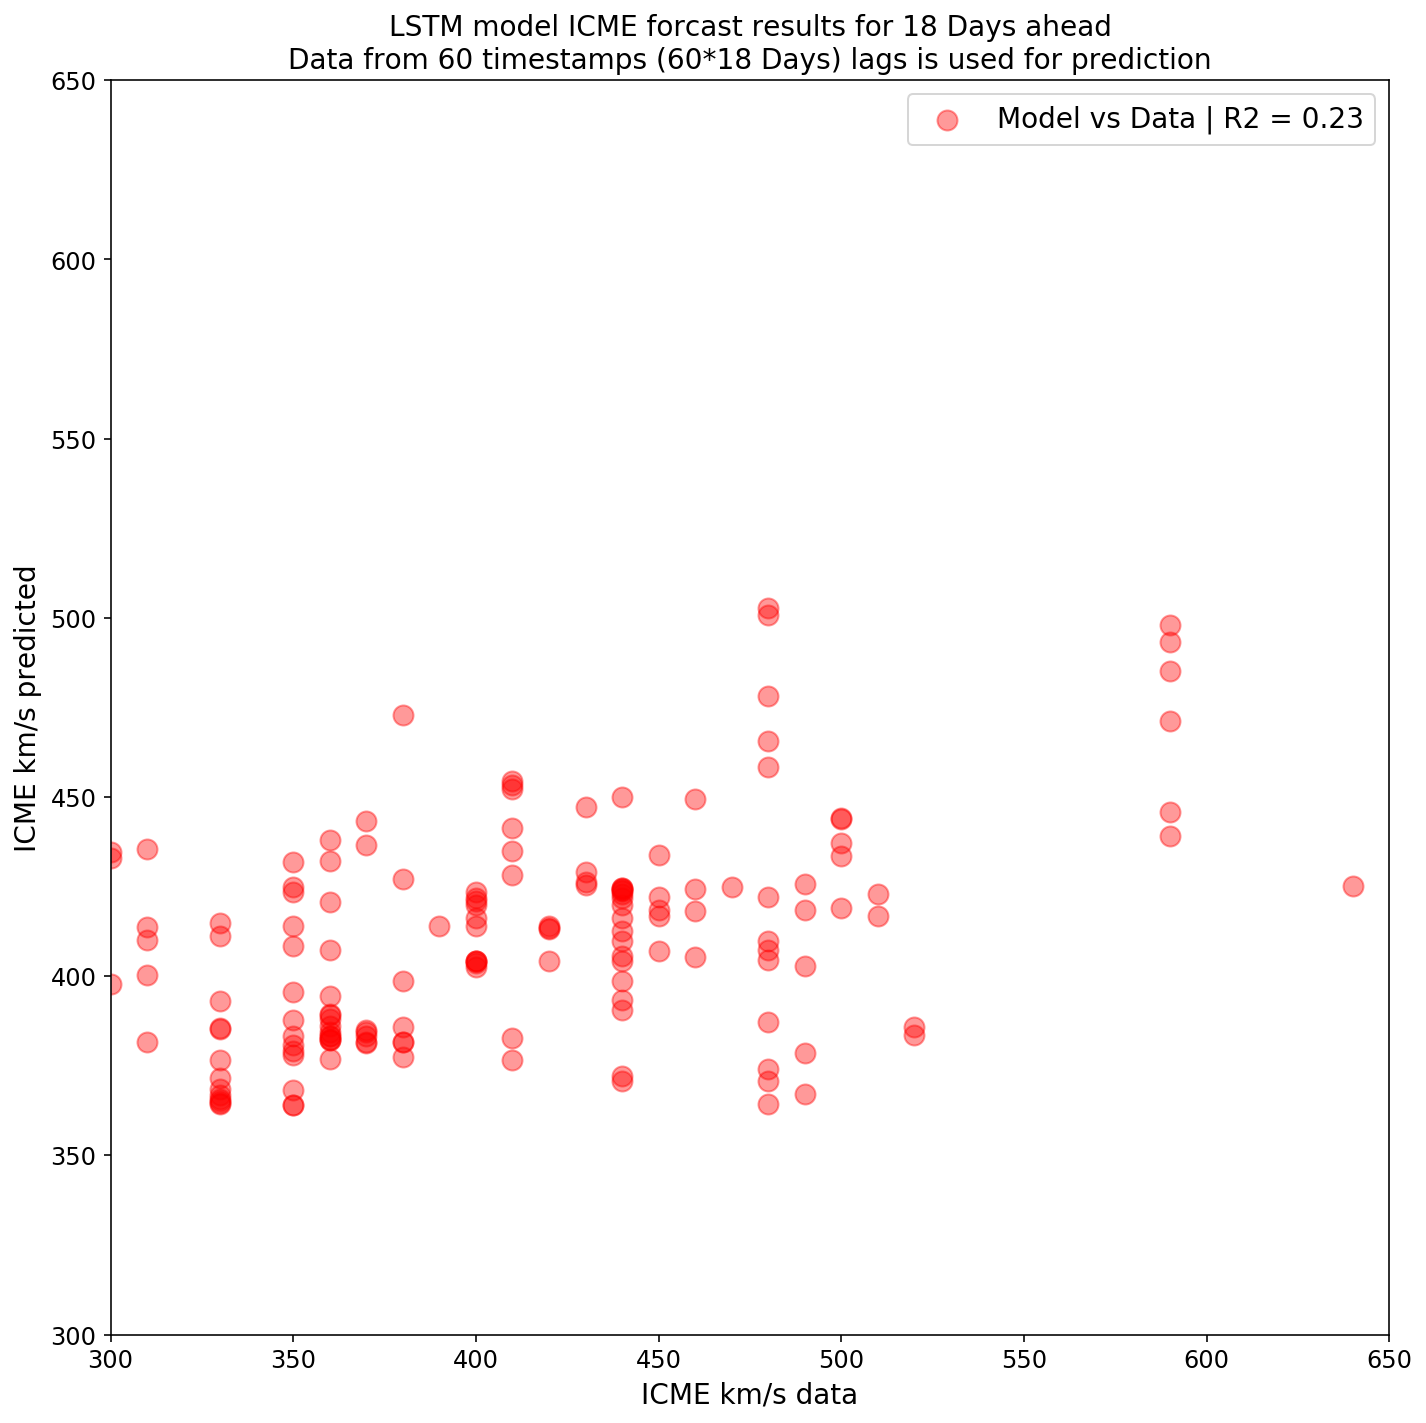

In [232]:
plt.figure(figsize=(10,10))

real_values = test_set[61:]
predited_values = predicted_ICME_reshaped_ser

plt.scatter(real_values, predited_values, color='r', 
            alpha=0.4, label=f'Model vs Data | R2 = {rs2}',s=100)
plt.xlabel("ICME km/s data", fontsize=14)
plt.ylabel("ICME km/s predicted", fontsize=14)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
# plt.axline([0, 0], [1, 1], color ='k')
# plt.hlines(300, 300, 600, linestyles="--", color ='k')
# plt.vlines(300, 300, 600, linestyles="--", color ='k')

plt.xlim(300,650), plt.ylim(300,650)

plt.title("LSTM model ICME forcast results for 18 \
Days ahead\nData from 60 timestamps (60*18 Days) lags is used for prediction", fontsize=14)

plt.tight_layout()
plt.legend(fontsize=14)

# plt.savefig("../Figures/" + section_fig_main_title + "LSTM12HoursAhead.png")

In [233]:

# Some functions to help out with
# lstm source https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
def plot_predictions(test, predicted, past, ahead):
    plt.figure(figsize=(16,8))
    
    plt.plot(df[(347-past):348], 'r',label='history')
    plt.vlines(df[347:348].index,0, 700, colors='k', linestyles='dashed')
    
    plt.plot(test[0:ahead], 'r^',label='Test')
    plt.plot(test[0:ahead], 'r')
#     test.plot(kind='scatter')
    
    plt.plot(predicted[0:ahead], color='blue',label='Predicted')
    plt.title('LSTM model', fontsize=10)
    plt.xlabel('ICME km/s', fontsize=10)
    plt.ylabel('ICME km/s', fontsize=10)
    
    
    
    
    plt.xticks(fontsize=10), plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.ylim(200,)
    
#     plt.show()


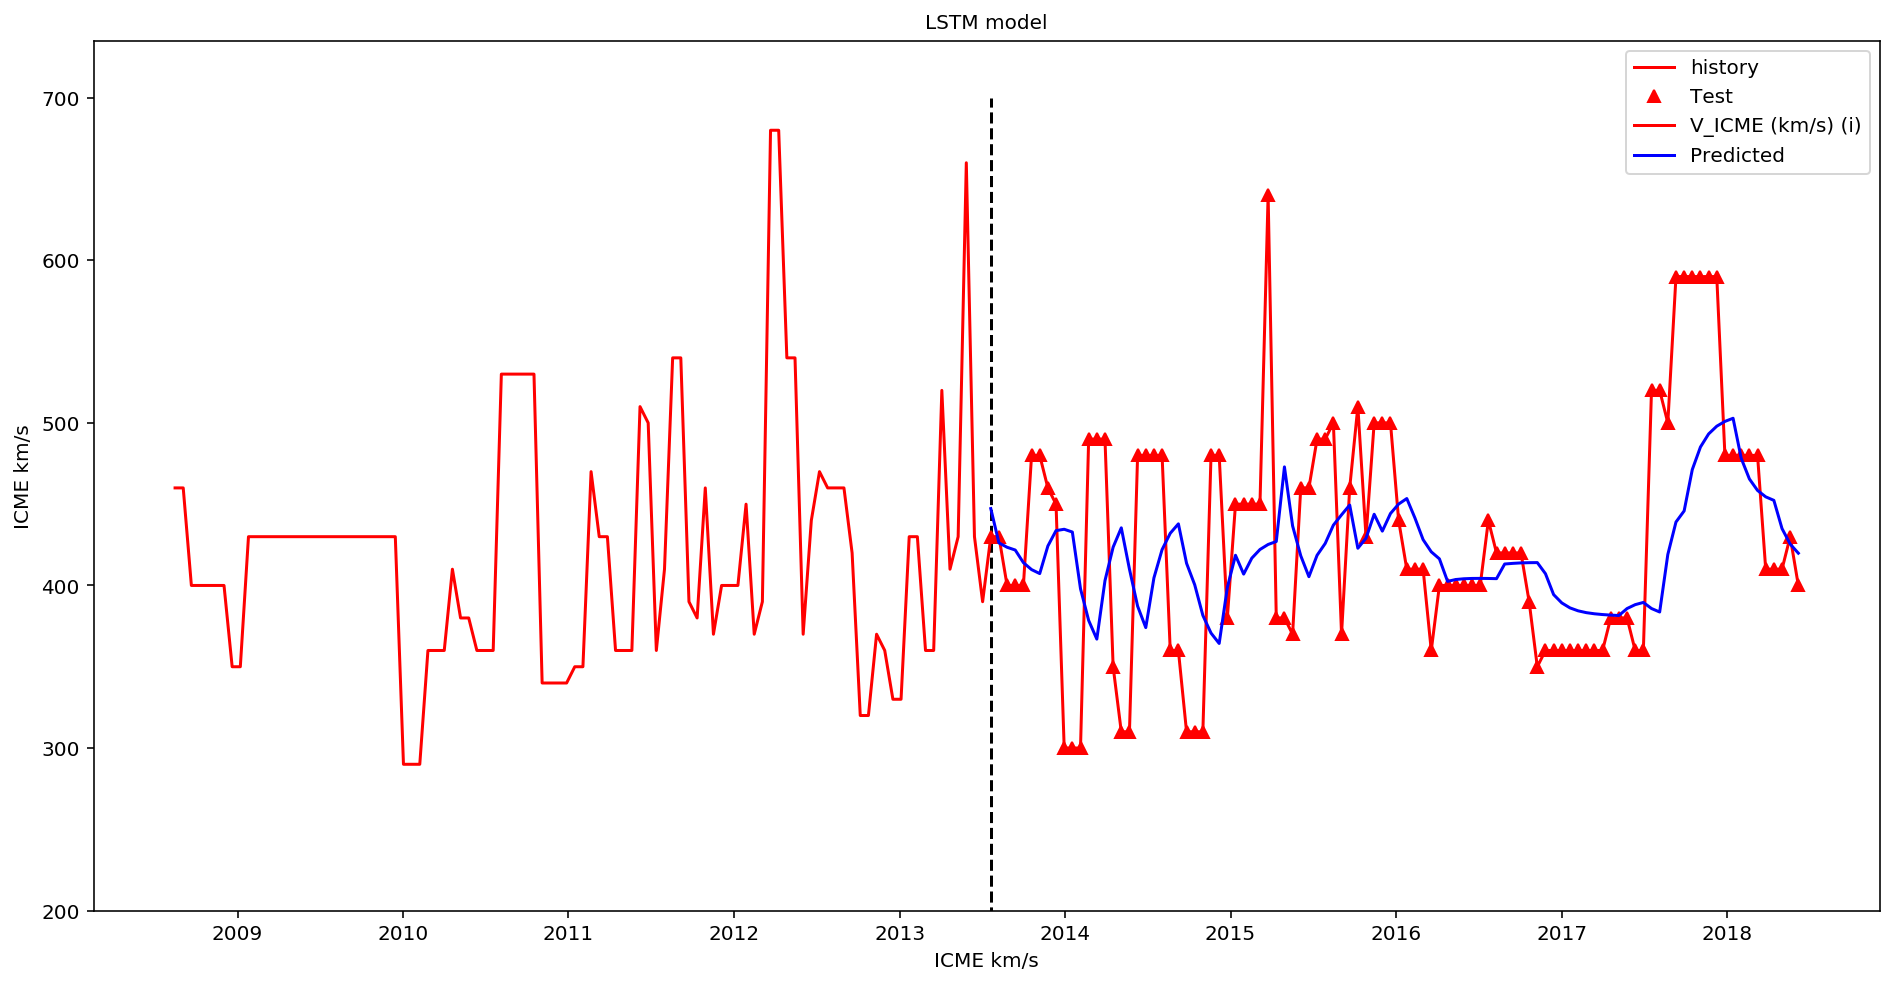

In [234]:
# Visualizing the results for LSTM
plot_predictions(test_set[61:], predicted_ICME_reshaped_ser, past=100, ahead=100)

In [203]:
# return_rmse(test_set_edited_np,predicted_temp)

In [204]:
# predicted_temp_reshape = np.reshape(predicted_temp, (156,))

In [205]:
# test_set_edited_np.shape


both test and predicted values are in same format and same shape.



In [206]:
# test_part = test_set_edited_np[0:3]
# test_part

In [207]:
# predicted_temp_reshape_part = predicted_temp_reshape[0:3]
# predicted_temp_reshape_part

## GIF visualization

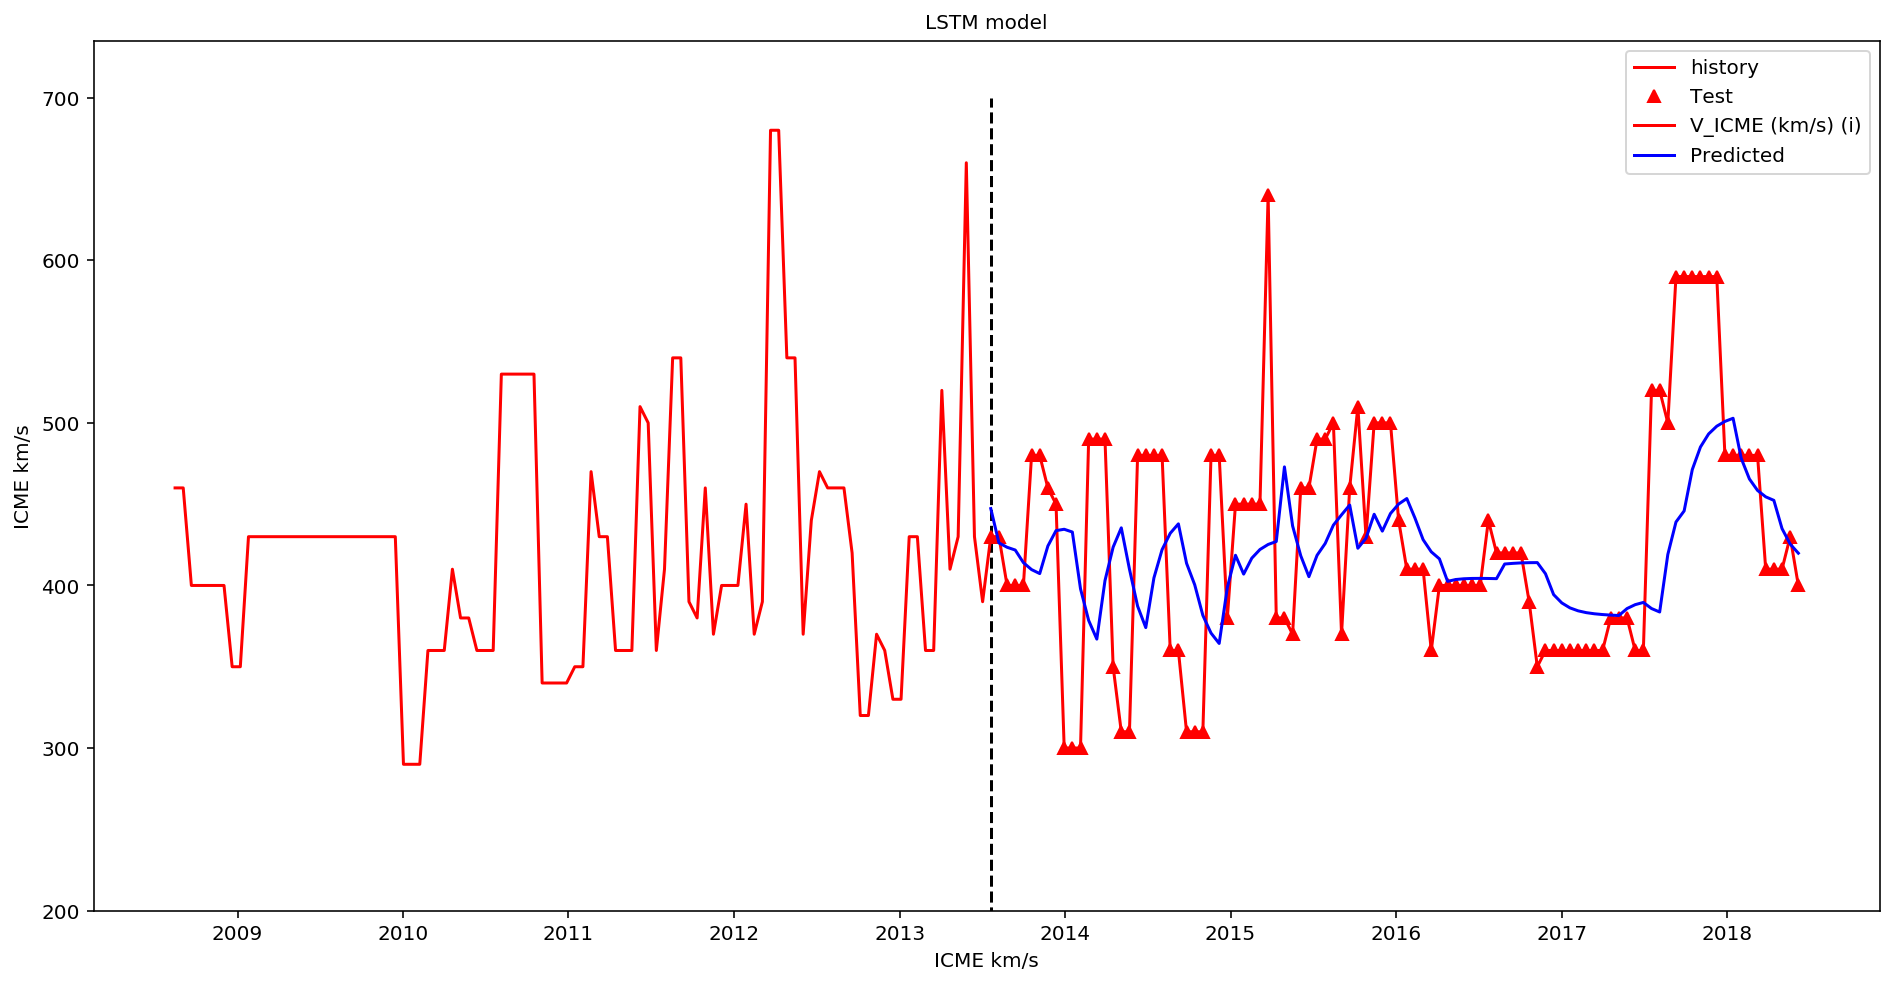

In [208]:
plot_predictions(test_set[61:], predicted_ICME_reshaped_ser, past=100, ahead=100)

In [209]:
@gif.frame
def plott(i):
    plot_predictions(test_set[61:], predicted_ICME_reshaped_ser, past=100, ahead=i)
    
    
    
#     test_part = test_set_edited_np[0:i]
#     predicted_temp_reshape_part = predicted_temp_reshape[0:i]

#     plot_predictions(test_part, predicted_temp_reshape_part)

In [210]:
frames = []    
for i in tqdm(range(0,156)):

    
    frame =  plott(i)
    frames.append(frame)

100%|██████████| 156/156 [00:20<00:00,  7.50it/s]


In [129]:
gif.save(frames, "../Figures/P03_02_LSTM_2_univar.gif", duration=2)